In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F0'
SS_VER = 'SS_VER_2_1'
%matplotlib widget


In [2]:
import chipwhisperer as cw

try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()

try:
    if SS_VER == "SS_VER_2_1":
        print("SS_VER_2_1")
        target_type = cw.targets.SimpleSerial2
    elif SS_VER == "SS_VER_2_0":
        raise OSError("SS_VER_2_0 is deprecated. Use SS_VER_2_1")
    else:
        print("SimpleSerial")
        target_type = cw.targets.SimpleSerial
except:
    SS_VER="SS_VER_1_1"
    target_type = cw.targets.SimpleSerial

try:
    target = cw.target(scope, target_type)
except:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope, target_type)


print("INFO: Found ChipWhisperer😍")

SS_VER_2_1
INFO: Found ChipWhisperer😍


In [3]:
if "STM" in PLATFORM or PLATFORM == "CWLITEARM" or PLATFORM == "CWNANO":
    prog = cw.programmers.STM32FProgrammer
    print("cw.programmers.STM32FProgrammer")
elif PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
    prog = cw.programmers.XMEGAProgrammer
elif "neorv32" in PLATFORM.lower():
    prog = cw.programmers.NEORV32Programmer
elif "SAM4S" in PLATFORM or PLATFORM == "CWHUSKY":
    prog = cw.programmers.SAM4SProgrammer
else:
    prog = None

cw.programmers.STM32FProgrammer


In [4]:
prog = cw.programmers.STM32FProgrammer
import time
time.sleep(0.05)
scope.default_setup()

scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 197355039                 to 218279313                
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 96000000                  to 29649879                 
scope.clock.adc_rate                     changed from 96000000.0                to 29649879.0               
scope.clock.clkgen_

In [5]:
def reset_target(scope):
    if PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
        scope.io.pdic = 'low'
        time.sleep(0.1)
        scope.io.pdic = 'high_z' #XMEGA doesn't like pdic driven high
        time.sleep(0.1) #xmega needs more startup time
    elif "neorv32" in PLATFORM.lower():
        raise IOError("Default iCE40 neorv32 build does not have external reset - reprogram device to reset")
    elif PLATFORM == "CW308_SAM4S" or PLATFORM == "CWHUSKY":
        print("CW308_SAM4S clause")
        scope.io.nrst = 'low'
        time.sleep(0.25)
        scope.io.nrst = 'high_z'
        time.sleep(0.25)
    else:
        # print("else clause")
        scope.io.nrst = 'low'
        time.sleep(0.05)
        scope.io.nrst = 'high_z'
        time.sleep(0.05)

In [6]:
%%bash -s "$PLATFORM" "$SS_VER"

cd mcu/basic-passwdcheck
make PLATFORM=$1 CRYPTO_TARGET=NONE SS_VER=$2 -j

SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CW308_STM32F0 
.
Welcome to another exciting ChipWhisperer target build!!
.
.
.
.
Compiling:
Compiling:
.
Compiling:
Compiling:
-en     basic-passwdcheck.c ...
-en     .././simpleserial/simpleserial.c ...
Compiling:
-en     .././hal/hal.c ...
-en     .././hal//stm32f0/stm32f0_hal.c ...
-en     .././hal//stm32f0/stm32f0_hal_lowlevel.c ...
.
Assembling: .././hal//stm32f0/stm32f0_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m0 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=objdir-CW308_STM32F0/stm32f0_startup.lst -I.././simpleserial/ -I.././hal/ -I.././hal/ -I.././hal//stm32f0 -I.././hal//stm32f0/CMSIS -I

In [7]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "mcu/basic-passwdcheck/basic-passwdcheck-CW308_STM32F0.hex")


Detected unknown STM32F ID: 0x440
Extended erase (0x44), this can take ten seconds or more
Attempting to program 4843 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4843 bytes


In [13]:
target.baud = 38400  # or 115200

# def read_until_prompt(prompt="Please enter password to continue: ", timeout=2.0):
#     """Drain UART until the password prompt appears. Works for str or bytes returns."""
#     t0 = time.time()
#     buf = ""  # use string buffer consistently
#     while time.time() - t0 < timeout:
#         chunk = target.read(timeout=0.1)
#         if not chunk:
#             continue
#         if isinstance(chunk, bytes):
#             chunk = chunk.decode(errors="ignore")
#         buf += chunk
#         if prompt in buf:
#             return buf
#     return buf  # whatever we collected
def cap_pass_trace(pass_guess):
    reset_target(scope)
    # _banner = read_until_prompt()
    # print(_banner)
    num_char = target.in_waiting()
    while num_char > 0:
        target.read(num_char, 10)
        time.sleep(0.01)
        num_char = target.in_waiting()

    scope.arm()
    target.write(pass_guess)
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    return trace

In [14]:
scope.adc.samples = 3000

In [10]:

trace_test = cap_pass_trace("h\n")

#Basic sanity check
assert(len(trace_test) == 3000)
print("✔️ OK to continue!")

(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 08


Timeout happened during acquisition
✔️ OK to continue!


In [46]:
# Try the baud used by your lab firmware; many 2_1B builds are 38400
target.baud = 38400  # or 115200

scope.trigger.triggers = "tio1"
scope.adc.samples = 5000
scope.adc.offset = 0
scope.adc.decimate = 1
scope.adc.timeout = 2.0
scope.io.target_pwr = True

def reset_target():
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high_z'
    time.sleep(0.15)

def read_until_prompt(prompt="Please enter password to continue: ", timeout=2.0):
    """Drain UART until the password prompt appears. Works for str or bytes returns."""
    t0 = time.time()
    buf = ""  # use string buffer consistently
    while time.time() - t0 < timeout:
        chunk = target.read(timeout=0.1)
        if not chunk:
            continue
        if isinstance(chunk, bytes):
            chunk = chunk.decode(errors="ignore")
        buf += chunk
        if prompt in buf:
            return buf
    return buf  # whatever we collected

def capture_one(password_line: str):
    """Reset, wait for prompt, arm, send password (must end with \\n), capture."""
    reset_target()

    # Option A (robust): wait until we actually see the prompt
    _banner = read_until_prompt()
    print(_banner)
    # Option B (quick): just flush instead of reading the banner
    # target.flush()

    scope.arm()
    target.write(password_line)  # must include '\n' to exit my_read()

    if scope.capture():
        print("Timeout: no trigger seen (check baud, trigger pin, newline).")
        trace = None
    else:
        trace = scope.get_last_trace()
        print("Captured trace length:", len(trace))

    # Read app response (FAIL / Access granted)
    resp = target.read(timeout=0.5)
    if isinstance(resp, bytes):
        resp = resp.decode(errors="ignore")
    print("Target said:", (resp or "").strip())

    return trace, resp

# Example:
# trace, resp = capture_one("guessme\n")   # wrong
trace, resp = capture_one("h0px3\n")   # correct

    ! *****Safe-o-matic 3000 Booting...
Decrypting database..[DONE]


Please enter password to continue: 
Captured trace length: 5000
Target said: Access gr


In [21]:
import chipwhisperer as cw

# --- Capture a couple of traces ---
trace1 = cap_pass_trace("h\n")
trace2 = cap_pass_trace("0\n")


# --- Plot them with ChipWhisperer helper ---
# cw.plot(trace1, label="h")*cw.plot(trace2, label="a")
cw.plot(trace1[0:200], label="h")*cw.plot(trace2[0:200], label="0")



:Overlay
   .Curve.H   :Curve   [x]   (y)
   .Curve.A_0 :Curve   [x]   (y)

In [30]:
from cwtraces import sca101_lab_data

cap_pass_trace = sca101_lab_data["lab2_1"]["cap_pass_trace"]

trace_test = cap_pass_trace("h\n")

print("Trace length:", len(trace_test))
cw.plot(cap_pass_trace("h\n")) * cw.plot(cap_pass_trace("0\n"))


Trace length: 3000


:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

In [23]:
from tqdm.notebook import tqdm
fig = cw.plot()
for c in tqdm('abcdefghijklmnopqrstuvwxyz0123456789'):
    trace = cap_pass_trace(c + "\n")
    fig *= cw.plot(trace[0:100])
    
fig

  0%|          | 0/36 [00:00<?, ?it/s]

:Overlay
   .Curve.I      :Curve   [x]   (y)
   .Curve.II     :Curve   [x]   (y)
   .Curve.III    :Curve   [x]   (y)
   .Curve.IV     :Curve   [x]   (y)
   .Curve.V      :Curve   [x]   (y)
   .Curve.VI     :Curve   [x]   (y)
   .Curve.VII    :Curve   [x]   (y)
   .Curve.VIII   :Curve   [x]   (y)
   .Curve.IX     :Curve   [x]   (y)
   .Curve.X      :Curve   [x]   (y)
   .Curve.XI     :Curve   [x]   (y)
   .Curve.XII    :Curve   [x]   (y)
   .Curve.XIII   :Curve   [x]   (y)
   .Curve.XIV    :Curve   [x]   (y)
   .Curve.XV     :Curve   [x]   (y)
   .Curve.XVI    :Curve   [x]   (y)
   .Curve.XVII   :Curve   [x]   (y)
   .Curve.XVIII  :Curve   [x]   (y)
   .Curve.XIX    :Curve   [x]   (y)
   .Curve.XX     :Curve   [x]   (y)
   .Curve.XXI    :Curve   [x]   (y)
   .Curve.XXII   :Curve   [x]   (y)
   .Curve.XXIII  :Curve   [x]   (y)
   .Curve.XXIV   :Curve   [x]   (y)
   .Curve.XXV    :Curve   [x]   (y)
   .Curve.XXVI   :Curve   [x]   (y)
   .Curve.XXVII  :Curve   [x]   (y)
   .Curve.XXVIII :Curve   [x]   (y)
   .Curve.XXIX   :Curve   [x]   (y)
   .Curve.XXX    :Curve   [x]   (y)
   .Curve.XXXI   :Curve   [x]   (y)
   .Curve.XXXII  :Curve   [x]   (y)
   .Curve.XXXIII :Curve   [x]   (y)
   .Curve.XXXIV  :Curve   [x]   (y)
   .Curve.XXXV   :Curve   [x]   (y)
   .Curve.XXXVI  :Curve   [x]   (y)
   .Curve.XXXVII :Curve   [x]   (y)

  0%|          | 0/36 [00:00<?, ?it/s]

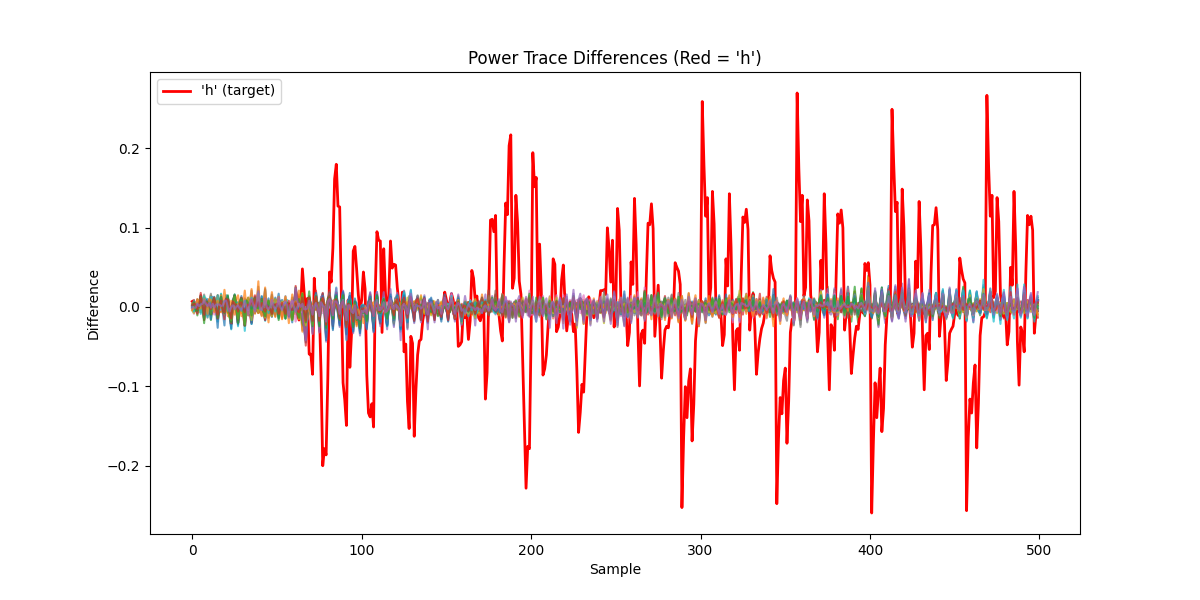

In [31]:
import matplotlib.pyplot as plt

ref_trace = cap_pass_trace("\x01\n")[0:500]
plt.figure(figsize=(12, 6))

for c in tqdm('abcdefghijklmnopqrstuvwxyz0123456789'): 
    trace = cap_pass_trace(c + "\n")[0:500]
    diff = trace - ref_trace
    
    if c == 'h':
        plt.plot(diff, color='red', linewidth=2, label=f"'{c}' (target)")
    else:
        plt.plot(diff, alpha=0.7)

plt.legend()
plt.title("Power Trace Differences (Red = 'h')")
plt.xlabel("Sample")
plt.ylabel("Difference")
plt.show()

In [32]:
import numpy as np

# ###################
# FIXED SOLUTION
# ###################

ref_trace = cap_pass_trace("\x00\n")  # Use null byte as reference

for c in 'abcdefghijklmnopqrstuvwxyz0123456789': 
    trace = cap_pass_trace(c + "\n")
    diff = np.sum(np.abs(trace - ref_trace))
    
    print("{:1} diff = {:.2f}".format(c, diff))
    
    # Automatically detect correct character with threshold
    if diff > 25.0:  # Adjust threshold based on your results
        print("*** FOUND: '{}' is likely the correct character! ***".format(c))

# ###################
# END SOLUTION
# ###################

a diff = 19.38
b diff = 18.67
c diff = 15.90
d diff = 23.75
e diff = 19.64
f diff = 19.75
g diff = 18.54
h diff = 214.52
*** FOUND: 'h' is likely the correct character! ***
i diff = 19.73
j diff = 21.22
k diff = 19.63
l diff = 18.03
m diff = 19.89
n diff = 23.87
o diff = 19.49
p diff = 20.54
q diff = 21.88
r diff = 20.39
s diff = 17.93
t diff = 20.15
u diff = 18.33
v diff = 18.93
w diff = 20.09
x diff = 19.29
y diff = 18.91
z diff = 20.77
0 diff = 18.49
1 diff = 19.29
2 diff = 21.31
3 diff = 19.98
4 diff = 21.55
5 diff = 17.65
6 diff = 21.51
7 diff = 21.11
8 diff = 21.40
9 diff = 20.87


In [ ]:
guessed_pw = ""

for position in range(0, 5):  
    biggest_diff = 0
    biggest_char = '\x01'
    ref_trace = cap_pass_trace(guessed_pw + "\x01\n")
    
    print(f"Finding character {position + 1}...")
    
    for c in 'abcdefghijklmnopqrstuvwxyz0123456789': 
        trace = cap_pass_trace(guessed_pw + c + "\n")
        diff = np.sum(np.abs(trace - ref_trace))

        if diff > biggest_diff:
            biggest_diff = diff
            biggest_char = c
            
    print(f"Position {position + 1}: '{biggest_char}' (diff: {biggest_diff:.2f})")
    guessed_pw += biggest_char
    print(f"Password so far: {guessed_pw}")

Finding character 1...
Position 1: 'h' (diff: 212.90)
Password so far: h
Finding character 2...
